# PGA: Capstone Project - The Battle of Neighborhoods (Week 1)
## Data retrieval and exploration

**Importing the libraries for our tasks.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim

import folium

import json
import requests
from pandas.io.json import json_normalize

### First data source: Scraping German cities wikipedia table

In [2]:
url='https://de.wikipedia.org/wiki/Liste_der_Gro%C3%9Fst%C3%A4dte_in_Deutschland'

dfs = pd.read_html(url, attrs={'class': 'wikitable sortable zebra mw-datatable'}, thousands=".")

cities = dfs[0].droplevel(level=0, axis=1)
cities.drop([81, 82], inplace=True)
print(cities.columns)

cities = cities[['Name', '2018', 'Fläche in km² (2016)', 'Bun­des­land']]
cities.rename(columns={"Name": "City", "2018": "Population", "Fläche in km² (2016)": "Area", "Bun­des­land": "State"}, inplace=True)

print(cities.shape)
print(cities.dtypes)
cities.head()

Index(['Rang (2018)', 'Name', '1939[2]', '1950', '1960', '1970', '1980',
       '1990', '2000', '2010', '2017', '2018', 'Fläche in km² (2016)',
       'Ew./km² (2018)', 'Be­völ­ke­rungs­ent­wick­lung [%] (2018 ggü. 2017)',
       'Großstadt erst­mals1', 'Bun­des­land'],
      dtype='object')
(81, 4)
City          object
Population    object
Area          object
State         object
dtype: object


,City,Population,Area,State
0,Berlin1,3644826,"891,68",Berlin
1,Hamburg1,1841179,"755,22",Hamburg
2,München,1471508,"310,70",Bayern
3,Köln1,1085664,"405,02",Nordrhein-Westfalen
4,Frankfurt am Main,753056,"248,31",Hessen


**Conversion of datatypes, replacement of umlauts, deletion of remark numbers.**

In [3]:
cities = cities.convert_dtypes()

cities['Population'] = cities['Population'].astype('int')
cities['Area'] = cities['Area'].str.replace(',','.').astype('float')

cities['City'] = cities['City'].str.replace('ü', 'ue')
cities['City'] = cities['City'].str.replace('ä', 'ae')
cities['City'] = cities['City'].str.replace('ö', 'oe')
cities['City'] = cities['City'].str.replace('ß', 'ss')
cities['City'] = cities['City'].str.replace('[^a-zA-Z ]', '')

cities['State'] = cities['State'].str.replace('ü', 'ue')
cities['State'] = cities['State'].str.replace('ä', 'ae')
cities['State'] = cities['State'].str.replace('ö', 'oe')
cities['State'] = cities['State'].str.replace('ß', 'ss')

print(cities.dtypes)
print(cities.shape)
cities

City           string
Population      int64
Area          float64
State          string
dtype: object
(81, 4)


,City,Population,Area,State
0,Berlin,3644826,891.68,Berlin
1,Hamburg,1841179,755.22,Hamburg
2,Muenchen,1471508,310.70,Bayern
3,Koeln,1085664,405.02,Nordrhein-Westfalen
4,Frankfurt am Main,753056,248.31,Hessen
...,...,...,...,...
76,Moers,103725,67.68,Nordrhein-Westfalen
77,Siegen,102836,114.69,Nordrhein-Westfalen
78,Hildesheim,101990,92.18,Niedersachsen
79,Cottbus,100219,165.15,Brandenburg


**Adding some more information for later on: the age statistics table for the German states. It will be merged with the dataframe in the next step.**

In [4]:
url='https://www.statistikportal.de/en/node/132'

dfs = pd.read_html(url, thousands=".")

age = dfs[1]                           

# reducing the levels
age = age.droplevel(level=0, axis=1)
age = age.droplevel(level=0, axis=1)
age = age.droplevel(level=1, axis=1)

# dropping summarizing row
# age.drop(columns=['unter 3', '3 – 6', '6 – 15', '75 und mehr'], inplace=True)
age.drop([16], inplace=True)

# renaming and replacing umlauts
age.rename(columns={"Bundesland": "State"}, inplace=True)
age['State'] = age['State'].str.replace('ü', 'ue')
age['State'] = age['State'].str.replace('ä', 'ae')
age['State'] = age['State'].str.replace('ö', 'oe')
age['State'] = age['State'].str.replace('ß', 'ss')

age = age.convert_dtypes()

for col in range(1, age.shape[1]):
    age[age.columns[col]] = age[age.columns[col]].str.replace(',','.').astype('float')

print(age.shape)
print(age.dtypes)
age.head()

(16, 12)
State           string
unter 3        float64
3 – 6          float64
6 – 15         float64
15 – 18        float64
18 – 25        float64
25 – 30        float64
30 – 40        float64
40 – 50        float64
50 – 65        float64
65 – 75        float64
75 und mehr    float64
dtype: object


,State,unter 3,3 – 6,6 – 15,15 – 18,18 – 25,25 – 30,30 – 40,40 – 50,50 – 65,65 – 75,75 und mehr
0,Baden-Wuerttemberg,2.6,2.7,9.2,3.3,8.7,6.1,12.0,16.6,19.6,10.5,8.9
1,Bayern,2.5,2.6,8.8,3.2,8.4,6.1,12.3,16.8,19.8,10.7,8.8
2,Berlin,2.9,2.6,7.2,2.3,8.3,7.9,14.1,16.4,19.0,11.4,7.8
3,Brandenburg,2.3,2.3,7.1,1.9,7.1,5.5,10.8,17.3,22.9,13.0,9.7
4,Bremen,2.4,2.4,7.7,2.7,9.1,7.1,12.3,15.6,19.5,11.6,9.6


Summarizing the age group percentages from 15-40 as "young" and from 40-75 as "old" and calculating the difference between them.

In [5]:
age['Population Share Age <40'] = (age['unter 3'] + age['3 – 6'] + age['6 – 15'] + age['15 – 18'] + age['18 – 25'] + age['25 – 30'] + age['30 – 40'])
age['Population Share Age >40'] = (age['40 – 50'] + age['50 – 65'] + age['65 – 75'] + age['75 und mehr'])

age = age[['State', 'Population Share Age <40', 'Population Share Age >40']]
    
print(age.dtypes)
print(age.shape)
age.head()

State                        string
Population Share Age <40    float64
Population Share Age >40    float64
dtype: object
(16, 3)


,State,Population Share Age <40,Population Share Age >40
0,Baden-Wuerttemberg,44.6,55.6
1,Bayern,43.9,56.1
2,Berlin,45.3,54.6
3,Brandenburg,37.0,62.9
4,Bremen,43.7,56.3


In [6]:
cities_age = pd.merge(cities,
                      age,
                      on='State',
                      how='right')
print(cities_age.shape)
cities_age.head()

(81, 6)


,City,Population,Area,State,Population Share Age <40,Population Share Age >40
0,Berlin,3644826,891.68,Berlin,45.3,54.6
1,Hamburg,1841179,755.22,Hamburg,47.1,53.1
2,Muenchen,1471508,310.70,Bayern,43.9,56.1
3,Nuernberg,518365,186.38,Bayern,43.9,56.1
4,Augsburg,295135,146.84,Bayern,43.9,56.1


**Histogram plot by population.**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fbf913150>]],
      dtype=object)

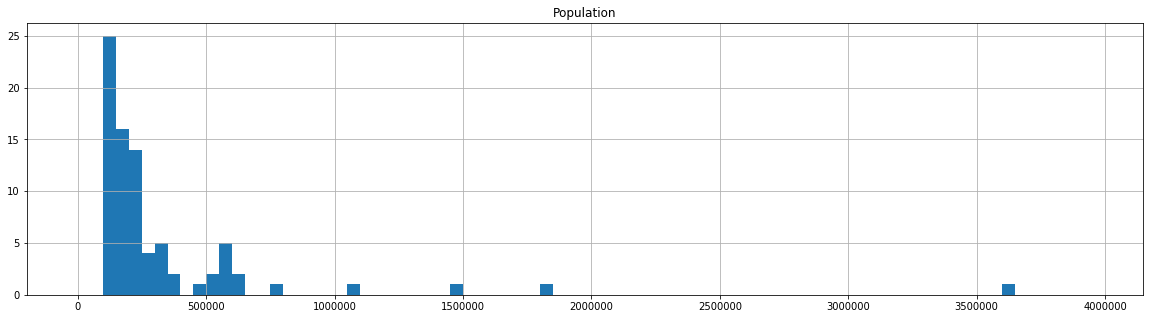

In [7]:
cities_age.hist(column='Population', bins=np.arange(0,4000000,50000), figsize=(20, 5))

**Statistical summary**

In [8]:
cities_age.describe().round(3)

,Population,Area,Population Share Age <40,Population Share Age >40
count,81.000,81.000,81.000,81.000
mean,328886.728,172.062,42.359,57.602
std,469869.304,128.462,2.068,2.022
min,100194.000,44.890,36.700,53.100
25%,126329.000,99.520,42.100,56.300
50%,188814.000,141.060,42.700,57.200
75%,313092.000,204.140,43.700,57.900
max,3644826.000,891.680,47.100,63.300


Half of the cities have a population of less than 188,814 and area of less than 141.06 sqkm.

**Adding geolocation**

In [9]:
lat_list=[]
lng_list=[]

for row in range(cities_age.shape[0]):
    geolocator = Nominatim(user_agent="coursera_capstone")
    location = geolocator.geocode('{}, Germany'.format(cities_age.iloc[row, 0]))
    try:
        lat_list.append(location.latitude)
        lng_list.append(location.longitude)
    except AttributeError:
        lat_list.append(np.nan)
        lng_list.append(np.nan)
        continue
    print(cities_age.iloc[row,0])

cities_age.insert(loc=3, column='Latitude', value=lat_list)
cities_age.insert(loc=4, column='Longitude', value=lng_list)

print(cities_age.shape)
print(cities_age.dtypes)
cities_age.head()

Berlin
Hamburg
Muenchen
Nuernberg
Augsburg
Regensburg
Ingolstadt
Wuerzburg
Fuerth
Erlangen
Koeln
Duesseldorf
Dortmund
Essen
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Muenster
Moenchengladbach 
Gelsenkirchen
Aachen
Krefeld
Oberhausen
Hagen
Hamm
Leverkusen
Solingen
Herne
Neuss
Paderborn
Bottrop
Recklinghausen
Bergisch Gladbach
Remscheid
Moers
Siegen
Guetersloh
Frankfurt am Main
Wiesbaden
Kassel
Darmstadt
Offenbach am Main
Stuttgart
Karlsruhe
Mannheim
Freiburg im Breisgau
Heidelberg
Ulm
Heilbronn
Pforzheim
Reutlingen
Leipzig
Dresden
Chemnitz
Bremen
Bremerhaven 
Hannover
Braunschweig
Oldenburg Oldb
Osnabrueck
Wolfsburg
Goettingen
Salzgitter 
Hildesheim
Kiel
Luebeck
Halle Saale
Magdeburg
Mainz
Ludwigshafen am Rhein
Koblenz
Trier
Erfurt
Jena
Rostock
Saarbruecken
Potsdam
Cottbus
(81, 8)
City                         string
Population                    int64
Area                        float64
Latitude                    float64
Longitude                   float64
State                        s

,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Population Share Age >40
0,Berlin,3644826,891.68,52.517037,13.388860,Berlin,45.3,54.6
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1,53.1
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9,56.1
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9,56.1
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9,56.1


In [10]:
# Show errors and drop the rows
print(cities_age.loc[cities_age['Latitude'].isna()])
cities_age.drop(cities_age[cities_age['Latitude'].isna()].index, axis=0, inplace=True)
print(cities_age.loc[cities_age['Latitude'].isna()])

                   City  Population   Area  Latitude  Longitude  \
27  Muelheim an derRuhr      170880  91.28       NaN        NaN   

                  State  Population Share Age <40  Population Share Age >40  
27  Nordrhein-Westfalen                      42.7                      57.2  
Empty DataFrame
Columns: [City, Population, Area, Latitude, Longitude, State, Population Share Age <40, Population Share Age >40]
Index: []


**Mapping the locations of the cities**

In [11]:
# creating the map
map_cities = folium.Map(location=[51.351, 10.454], zoom_start=5.5)

# add markers of citis to map
for lat, lng, city, pop in zip(cities_age['Latitude'], cities_age['Longitude'], cities_age['City'], cities_age['Population']):
    label = '{} (Population: {})'.format(city, pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cities)

map_cities

### Second data source: Retrieving the venues for the cities from Foursquare.

In [12]:
CLIENT_ID = 'AOUOE4WYOQXAMZABF1J3HUQCXZ0GBEETIUCZDQOUYR0JGRQD' # your Foursquare ID
CLIENT_SECRET = 'MCY5M5APBTGR1J2QR20PQLZ2YVJBXRBG4OOML1ZHAMLHYCGR' # your Foursquare Secret
VERSION = '20200522' # Foursquare API version
LIMIT = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AOUOE4WYOQXAMZABF1J3HUQCXZ0GBEETIUCZDQOUYR0JGRQD
CLIENT_SECRET:MCY5M5APBTGR1J2QR20PQLZ2YVJBXRBG4OOML1ZHAMLHYCGR


In [16]:
def getNearbyVenues(cities, latitudes, longitudes, radius):
    
    venues_list=[]
    for city, lat, lng in zip(cities, latitudes, longitudes):
        print(city)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()['response']['groups'][0]['items']
        except KeyError:
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

**Calculating the search radius using the median city size (area)**

In [17]:
radius = round(np.sqrt(cities_age['Area'].median()/np.pi)*1000)
radius

6747.0

In [18]:
cities_age_venues = getNearbyVenues(cities=cities_age['City'],
                                   latitudes=cities_age['Latitude'],
                                   longitudes=cities_age['Longitude'],
                                   radius=radius
                                  )

Berlin
Hamburg
Muenchen
Nuernberg
Augsburg
Regensburg
Ingolstadt
Wuerzburg
Fuerth
Erlangen
Koeln
Duesseldorf
Dortmund
Essen
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Muenster
Moenchengladbach 
Gelsenkirchen
Aachen
Krefeld
Oberhausen
Hagen
Hamm
Leverkusen
Solingen
Herne
Neuss
Paderborn
Bottrop
Recklinghausen
Bergisch Gladbach
Remscheid
Moers
Siegen
Guetersloh
Frankfurt am Main
Wiesbaden
Kassel
Darmstadt
Offenbach am Main
Stuttgart
Karlsruhe
Mannheim
Freiburg im Breisgau
Heidelberg
Ulm
Heilbronn
Pforzheim
Reutlingen
Leipzig
Dresden
Chemnitz
Bremen
Bremerhaven 
Hannover
Braunschweig
Oldenburg Oldb
Osnabrueck
Wolfsburg
Goettingen
Salzgitter 
Hildesheim
Kiel
Luebeck
Halle Saale
Magdeburg
Mainz
Ludwigshafen am Rhein
Koblenz
Trier
Erfurt
Jena
Rostock
Saarbruecken
Potsdam
Cottbus


In [19]:
print(cities_age_venues.dtypes)
cities_age_venues.head()

City               object
City Latitude     float64
City Longitude    float64
Venue              object
Venue Category     object
dtype: object


,City,City Latitude,City Longitude,Venue,Venue Category
0,Berlin,52.517037,13.38886,Dussmann das KulturKaufhaus,Bookstore
1,Berlin,52.517037,13.38886,Dussmann English Bookshop,Bookstore
2,Berlin,52.517037,13.38886,Konzerthaus Berlin,Concert Hall
3,Berlin,52.517037,13.38886,Gendarmenmarkt,Plaza
4,Berlin,52.517037,13.38886,Brandenburger Tor,Monument / Landmark


**Creating the onehot encoded and the subsequentally grouped dataframe for use in the analysis part.**

In [51]:
# onehot
cities_age_venues_onehot = pd.get_dummies(cities_age_venues[['Venue Category']], prefix="", prefix_sep="")
cities_age_venues_onehot['City'] = cities_age_venues['City'] 
fixed_columns = [cities_age_venues_onehot.columns[-1]] + list(cities_age_venues_onehot.columns[:-1])
cities_age_venues_onehot = cities_age_venues_onehot[fixed_columns]

# grouped by city
cities_age_venues_grouped = cities_age_venues_onehot.groupby('City').mean().reset_index()
cities_age_venues_grouped.head()

,City,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Apple Wine Pub,Aquarium,Arcade,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.01,0.0,0.0,0.0,0.010000,0.000000
1,Augsburg,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.010000,0.000000
2,Bergisch Gladbach,0.0,0.0,0.0,0.0,0.025316,0.00,0.0,0.0,0.0,...,0.000000,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.012658
3,Berlin,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.000000,0.01,0.01,0.0,0.03,0.0,0.0,0.0,0.000000,0.000000
4,Bielefeld,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.011364,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.011364,0.000000


**Selecting the top 10 venues per city and creating.**

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_age_venues_grouped_top10 = pd.DataFrame(columns=columns)
cities_age_venues_grouped_top10['City'] = cities_age_venues_grouped['City']

for ind in np.arange(cities_age_venues_grouped.shape[0]):
    cities_age_venues_grouped_top10.iloc[ind, 1:] = return_most_common_venues(cities_age_venues_grouped.iloc[ind, :], num_top_venues)

print(cities_age_venues_grouped_top10.shape)
cities_age_venues_grouped_top10.head()

(80, 11)


,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aachen,Bar,German Restaurant,Supermarket,Park,Italian Restaurant,Plaza,Bakery,Ice Cream Shop,Café,Music Venue
1,Augsburg,Italian Restaurant,Café,Beer Garden,Steakhouse,Bar,German Restaurant,Plaza,Hotel,Bakery,Turkish Restaurant
2,Bergisch Gladbach,Supermarket,Drugstore,Hotel,Italian Restaurant,Hardware Store,Tram Station,Bakery,Steakhouse,Chinese Restaurant,Clothing Store
3,Berlin,Coffee Shop,Park,Bookstore,Ice Cream Shop,Monument / Landmark,Wine Bar,Bakery,Gourmet Shop,Pastry Shop,Bar
4,Bielefeld,Supermarket,Hotel,Café,Bar,Bakery,Park,Big Box Store,Italian Restaurant,Sushi Restaurant,Middle Eastern Restaurant


Grouping the Foursquare dataframe by city to see how many venues were found per city.
Adding the number of venues and some additional metrics, venue count per population and venue count per area, to the grouped dataframe.

In [53]:
cities_age_venues_count = cities_age_venues.groupby(['City']).count()

cities_age_venues_count = cities_age_venues_count.drop(columns=['City Latitude', 'City Longitude', 'Venue Category']).rename(columns={"Venue": "Venues"})

cities_age_venues_count = pd.merge(cities_age,
                                   cities_age_venues_count,
                                   on='City',
                                   how='left')

cities_age_venues_count['Venues per Population'] = cities_age_venues_count.apply(lambda row: row.Venues/row.Population, axis = 1)
cities_age_venues_count = cities_age_venues_count.round({'Venues per Population': 6})

cities_age_venues_count['Venues per Area'] = cities_age_venues_count.apply(lambda row: row.Venues/row.Area, axis = 1)
cities_age_venues_count = cities_age_venues_count.round({'Venues per Area': 6})

print(cities_age_venues_count.dtypes)
cities_age_venues_count.head()

City                         object
Population                    int64
Area                        float64
Latitude                    float64
Longitude                   float64
State                        string
Population Share Age <40    float64
Population Share Age >40    float64
Venues                        int64
Venues per Population       float64
Venues per Area             float64
dtype: object


,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Population Share Age >40,Venues,Venues per Population,Venues per Area
0,Berlin,3644826,891.68,52.517037,13.388860,Berlin,45.3,54.6,100,0.000027,0.112148
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1,53.1,100,0.000054,0.132412
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9,56.1,100,0.000068,0.321854
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9,56.1,100,0.000193,0.536538
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9,56.1,100,0.000339,0.681013


**Merging everything into one big dataframe.**

In [54]:
cities_age_venues_grouped = pd.merge(cities_age_venues_grouped,
                                     cities_age_venues_grouped_top10,
                                     on='City',
                                     how='left')
cities_age_venues_grouped = pd.merge(cities_age_venues_count,
                                     cities_age_venues_grouped,
                                     on='City',
                                     how='left')
cities_age_venues_grouped.head()

,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Population Share Age >40,Venues,Venues per Population,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berlin,3644826,891.68,52.517037,13.388860,Berlin,45.3,54.6,100,0.000027,...,Coffee Shop,Park,Bookstore,Ice Cream Shop,Monument / Landmark,Wine Bar,Bakery,Gourmet Shop,Pastry Shop,Bar
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1,53.1,100,0.000054,...,Coffee Shop,Café,Hotel,Park,Seafood Restaurant,Pizza Place,Cocktail Bar,Theater,Vietnamese Restaurant,Supermarket
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9,56.1,100,0.000068,...,Café,Plaza,Italian Restaurant,Hotel,Beach,Cocktail Bar,Ice Cream Shop,German Restaurant,Art Museum,Gourmet Shop
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9,56.1,100,0.000193,...,Café,Park,Coffee Shop,Gym / Fitness Center,History Museum,Historic Site,Beer Garden,Greek Restaurant,Burger Joint,Bakery
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9,56.1,100,0.000339,...,Italian Restaurant,Café,Beer Garden,Steakhouse,Bar,German Restaurant,Plaza,Hotel,Bakery,Turkish Restaurant


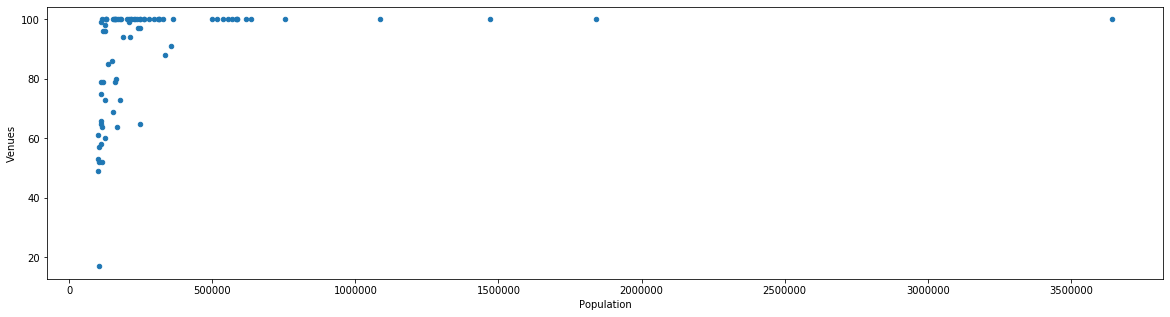

In [55]:
cities_age_venues_grouped.plot.scatter(x='Population', y='Venues', figsize=(20,5))

Of course, bigger cities reach the maximum retrievable count of 100 venues easily.

But one can see, that there is quite a range in the venue count for the smaller cities.

To make this range more distinctable one can plot the population on a logarithmic axis.

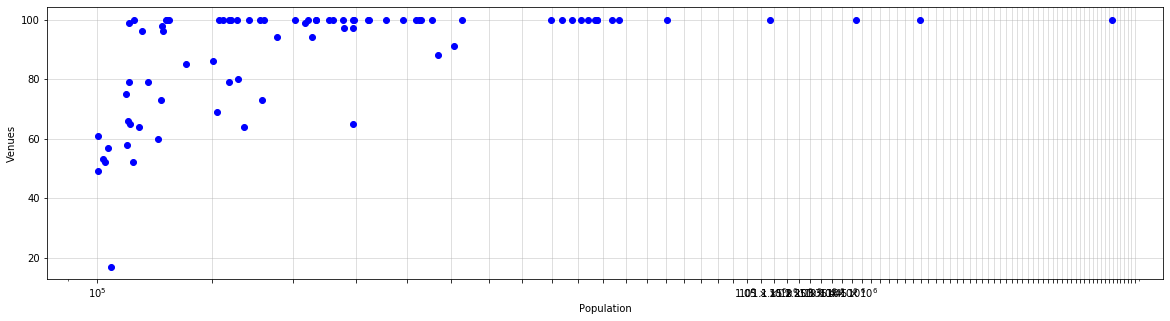

In [56]:
x_data = cities_age_venues_grouped['Population']
y_data = cities_age_venues_grouped['Venues']

fig = plt.figure(figsize=(20,5))
ax = plt.gca(xscale='log', xticks=np.arange(0,4000000,50000))
ax.plot(x_data, y_data, 'o', c='blue')
ax.set_xlabel('Population')
ax.set_ylabel('Venues')
ax.grid(alpha=0.5)

Now one can see that almost every city with a population bigger than 250k reaches the limit of 100 venue counts (except for two cities).

In [57]:
cities_age_venues_grouped.loc[cities_age_venues_grouped['Venues']==100]

,City,Population,Area,Latitude,Longitude,State,Population Share Age <40,Population Share Age >40,Venues,Venues per Population,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berlin,3644826,891.68,52.517037,13.388860,Berlin,45.3,54.6,100,0.000027,...,Coffee Shop,Park,Bookstore,Ice Cream Shop,Monument / Landmark,Wine Bar,Bakery,Gourmet Shop,Pastry Shop,Bar
1,Hamburg,1841179,755.22,53.543764,10.009913,Hamburg,47.1,53.1,100,0.000054,...,Coffee Shop,Café,Hotel,Park,Seafood Restaurant,Pizza Place,Cocktail Bar,Theater,Vietnamese Restaurant,Supermarket
2,Muenchen,1471508,310.70,48.137108,11.575382,Bayern,43.9,56.1,100,0.000068,...,Café,Plaza,Italian Restaurant,Hotel,Beach,Cocktail Bar,Ice Cream Shop,German Restaurant,Art Museum,Gourmet Shop
3,Nuernberg,518365,186.38,49.453872,11.077298,Bayern,43.9,56.1,100,0.000193,...,Café,Park,Coffee Shop,Gym / Fitness Center,History Museum,Historic Site,Beer Garden,Greek Restaurant,Burger Joint,Bakery
4,Augsburg,295135,146.84,48.366804,10.898697,Bayern,43.9,56.1,100,0.000339,...,Italian Restaurant,Café,Beer Garden,Steakhouse,Bar,German Restaurant,Plaza,Hotel,Bakery,Turkish Restaurant
7,Wuerzburg,127880,87.63,49.792450,9.932966,Bayern,43.9,56.1,100,0.000782,...,Supermarket,Café,Hotel,Drugstore,Plaza,German Restaurant,Historic Site,Fast Food Restaurant,Wine Bar,Furniture / Home Store
8,Fuerth,127748,63.35,49.477263,10.989616,Bayern,43.9,56.1,100,0.000783,...,Café,German Restaurant,Park,Gastropub,Gym / Fitness Center,Greek Restaurant,Burger Joint,Supermarket,Hotel,Vegetarian / Vegan Restaurant
10,Koeln,1085664,405.02,50.938361,6.959974,Nordrhein-Westfalen,42.7,57.2,100,0.000092,...,Café,Park,Coffee Shop,Burger Joint,Ice Cream Shop,Italian Restaurant,Gym / Fitness Center,Pedestrian Plaza,Hotel,German Restaurant
11,Duesseldorf,619294,217.41,51.225402,6.776314,Nordrhein-Westfalen,42.7,57.2,100,0.000161,...,Café,Park,Japanese Restaurant,Pizza Place,Brewery,Coffee Shop,Hotel,Art Museum,Plaza,Bar
12,Dortmund,587010,280.71,51.514227,7.465279,Nordrhein-Westfalen,42.7,57.2,100,0.000170,...,Café,Italian Restaurant,Plaza,Turkish Restaurant,Park,Coffee Shop,Nightclub,German Restaurant,Ice Cream Shop,Sushi Restaurant


45 cities reach the limit of 100 venues per API call. They will be dropped in the Analysis part, but for now I will save the whole dataframe to csv.

In [58]:
cities_age_venues_grouped.to_csv('cities_age_venues_grouped.csv')

## The dataframe is now ready for our data science methods.